In [6]:
from mae451.geometry.airfoils.kulfan import Kulfan
from mae451.analysis.apis.xfoil.run import run as run_xfoil
import os
import numpy as np
import json
import pandas as pd

import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})
lgfs = 22
import matplotlib
%matplotlib inline
colors = ['#0065cc', '#e69f00', '#009e73', '#d55e00', '#56b4ff', '#fca7c7', '#ede13f', '#666666', '#000000']
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=colors)

In [2]:
def polarPlot(dataList, linecolors=None, linestyles=None):
    plt.ioff()
    for data in dataList:
        assert(isinstance(data,list))
        for de in data:
            # print(de)
            # print(type(de))
            assert(isinstance(de,dict))

    colorCycle = ['Blues','Oranges','Greens','Purples','Reds']
    if linecolors is None:
        assert(len(dataList)<=len(colorCycle))

    dataframeList = []
    for data in dataList:
        dataDict = {}
        dataDict['alpha']    = [] #np.zeros(len(data))
        dataDict['cl']       = [] #np.zeros(len(data))
        dataDict['cd']       = [] #np.zeros(len(data))
        dataDict['cm']       = [] #np.zeros(len(data))
        dataDict['xtp_u']    = [] #np.zeros(len(data))
        dataDict['xtp_l']    = [] #np.zeros(len(data))    
        dataDict['xtr_u']    = [] #np.zeros(len(data))
        dataDict['xtr_l']    = [] #np.zeros(len(data))
        dataDict['re']       = [] #np.zeros(len(data))
        dataDict['m']        = [] #np.zeros(len(data))
        dataDict['n_crit']   = [] #np.zeros(len(data))
        dataDict['n_panels'] = [] #np.zeros(len(data))

        for i,rdata in enumerate(data):
            if rdata is not None:
                for ky in dataDict.keys():
                    if ky in list(rdata.keys()):
                        vl = rdata[ky]
                    elif ky == 're':
                        vl = rdata['Re']
                    elif ky == 'm':
                        vl = rdata['M']
                    elif ky == 'n_crit':
                        vl = rdata['N_crit']
                    elif ky == 'xtr_u':
                        vl = rdata['xtr_top']
                    elif ky == 'xtr_l':
                        vl = rdata['xtr_bot']
                    elif ky == 'xtp_u':
                        vl = rdata['xtp_top']
                    elif ky == 'xtp_l':
                        vl = rdata['xtp_bot']
                    elif ky == 'n_panels':
                        vl = rdata['N_panels']
                    else:
                        raise ValueError('Could not find key: %s'%(ky))
                    dataDict[ky].append( vl )

        assert( len(np.unique(dataDict['m'])) == 1)
        assert( len(np.unique(dataDict['xtp_u'])) == 1)
        assert( len(np.unique(dataDict['xtp_l'])) == 1)
        assert( len(np.unique(dataDict['n_crit'])) == 1)
        assert( len(np.unique(dataDict['n_panels'])) == 1)

        df = pd.DataFrame.from_dict(dataDict)
        dataframeList.append(df)

    re_min = np.inf
    re_max = 0.0

    for df in dataframeList:
        re_arr = np.array(df['re'].to_list())
        re_min = min([re_min, min(re_arr)])
        re_max = max([re_max, max(re_arr)])

    fig = plt.figure(figsize=(20,16), dpi=300)
    gs = GridSpec(2,2, figure=fig)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,1])
    ax4 = fig.add_subplot(gs[1,0])

    for i,df in enumerate(dataframeList):
        for Re_value in np.unique(np.array(df['re'].to_list()).round(0)):
            if re_min == re_max:
                if linecolors is not None:
                    plot_color = linecolors[i]
                else:
                    plot_color = [0,0,1]
            else:
                if linecolors is not None:
                    plot_color = linecolors[i]
                else:
                    color_frac = (np.log10(Re_value) - np.log10(re_min)) / (np.log10(re_max)-np.log10(re_min))
                    plot_color = [0,0,1]

            if linestyles is not None:
                line_style = linestyles[i]
            else:
                line_style = '-'

            commonRe = df.loc[(abs(df['re'] - Re_value) <= 1)]
            commonRe.sort_values('alpha')
            if i==0:
                ax1.plot(commonRe['cd'],commonRe['cl'], label='Re=%.2e'%(Re_value), color = plot_color, ls=line_style)
            else:
                ax1.plot(commonRe['cd'],commonRe['cl'], color = plot_color, ls=line_style)
            ax1.set_xlim([0,0.05])
            ax1.set_ylabel('$C_L$')
            ax1.set_xlabel('$C_D$')
            ax1.grid(1)
            ax1.legend()

            if i==0:
                ax2.plot(commonRe['alpha'],commonRe['cl'], label='Re=%.2e'%(Re_value), color = plot_color, ls=line_style)
            else:
                ax2.plot(commonRe['alpha'],commonRe['cl'], color = plot_color, ls=line_style)
            ax2.set_ylabel('$C_L$')
            ax2.set_xlabel(r'$\alpha$')
            ax2.grid(1)
            ax2.legend()

            if i==0:
                ax3.plot(commonRe['alpha'],commonRe['cm'], label='Re=%.2e'%(Re_value), color = plot_color, ls=line_style)
            else:
                ax3.plot(commonRe['alpha'],commonRe['cm'], color = plot_color, ls=line_style)
            ax3.set_ylabel('$C_M$')
            ax3.set_xlabel(r'$\alpha$')
            ax3.grid(1)
            ax3.legend()

            if i==0:
                ax4.plot(commonRe['cl'],commonRe['cl']/commonRe['cd'], label='Re=%.2e'%(Re_value), color = plot_color, ls=line_style)
            else:
                ax4.plot(commonRe['cl'],commonRe['cl']/commonRe['cd'], color = plot_color, ls=line_style)
            ax4.set_ylabel('$L/D$')
            ax4.set_xlabel(r'$C_L$')
            ax4.grid(1)
            ax4.legend()

    plt.tight_layout()

    return fig


In [3]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import math

def handleZeroDivide(num,dem):
    if dem == 0:
        return np.inf
    else:
        return num/dem
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def get_colors(N, selectedMap, lower = 0.15, upper = 0.75):
    cmap = plt.get_cmap(selectedMap)
    cmap = truncate_colormap(cmap,lower, upper)
    norm = plt.Normalize(0, N - 1)
    colors = cmap(norm(np.arange(N)))
    return colors

def get_fractional_color(frac, selectedMap, lower=0.15, upper=0.75):
    colors = get_colors(101, selectedMap, lower, upper)
    return(colors[int(math.floor(frac*100.0))])

def computeNormals(xdata, ydata):
    xmin_index = xdata.index(min(xdata))
    normals = []
    for i, x in enumerate(xdata):
        y = ydata[i]

        if i == 0:
            x_p1 = xdata[i+1]
            x_m1 = x
            y_p1 = ydata[i+1]
            y_m1 = y

            dxdy = handleZeroDivide(y_p1-y, x_p1-x)

        elif i == len(xdata)-1:
            x_p1 = x
            x_m1 = xdata[i-1]
            y_p1 = y
            y_m1 = ydata[i-1]

            dxdy = handleZeroDivide(y-y_m1, x-x_m1)

        else:
            x_p1 = xdata[i+1]
            x_m1 = xdata[i-1]
            y_p1 = ydata[i+1]
            y_m1 = ydata[i-1]

            dxdy_p1 = handleZeroDivide(y_p1-y, x_p1-x)
            dxdy_m1 = handleZeroDivide(y-y_m1, x-x_m1)

            if dxdy_p1!=dxdy_m1 and max([dxdy_p1,dxdy_m1])==np.inf:
                dxdy = min([dxdy_p1,dxdy_m1])
            else:
                dxdy = handleZeroDivide(y_p1-y_m1, x_p1-x_m1)

        if dxdy == 0.0:
            normal = [0,1]
        elif dxdy == np.inf:
            normal = [1,0]
        else:
            normal =  [ 1/(1+1/dxdy**2)**0.5, -1/dxdy/(1+1/dxdy**2)**0.5 ]

        if i<=xmin_index:
            # in upper
            if normal[1] < 0:
                normal = [-1*normal[0], -1*normal[1]]
        else:
            if x>1:
                #in wake
                if normal[1] < 0:
                    normal = [-1*normal[0], -1*normal[1]]
            else:
                #in lower
                if normal[1] > 0:
                    normal = [-1*normal[0], -1*normal[1]]

        if i < xmin_index+3 and i > xmin_index-3:
            # leading edge points need to point to left, but sometimes there are issues
            if normal[0] > 0:
                normal = [-1*normal[0], -1*normal[1]]

        normals.append(normal)

    return normals

def standardPlot(dataList):
    plt.ioff()
    if len(dataList) > 3:
        raise ValueError('You really dont want to do this, compare fewer data sets (please dont do more than 2, but this function will allow 3)')
        
    if len(dataList)==1:
        figHeight = 8
    elif len(dataList)==2:
        figHeight = 10
    else:
        figHeight = 6+2*len(dataList)
    fig = plt.figure(figsize=(10,figHeight), dpi=300)

    gs = GridSpec(len(dataList)+2, 1, figure=fig)
    ax1 = fig.add_subplot(gs[0:2, 0])
    afl_axes = [fig.add_subplot(gs[2+i, 0]) for i in range(0,len(dataList))]

    ax1.plot([-0.1,1.1],[0,0],color='k')
    tickHeight = 0.05
    for xtick in np.linspace(0,1,11):
        ax1.plot([xtick,xtick],[-tickHeight,tickHeight],color='k')

    xlims = [-0.1,1.1]
    ax1.set_xlim(xlims)

    ax1.set_ylabel(r'$C_p$')
    ax1.spines[['right', 'top', 'bottom']].set_visible(False)
    ax1.set_xticks([])

    for ax in afl_axes:
        ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    
    if len(dataList) == 1:
        colors_lower = ['#d55e00']
        colors_upper = ['#0065cc']
    elif len(dataList) == 2:
        colors_lower = ['#d55e00','#fca7c7']
        colors_upper = ['#0065cc','#56b4ff']
    else:
        colors_upper=get_colors(len(dataList),'Blues_r')
        colors_lower=get_colors(len(dataList),'Reds_r')
        
    for ii,data in enumerate(dataList):
        # data has:
        #    data['alpha'] 
        #    data['cl']
        #    data['cm']
        #    data['cd']
        #    data['re']
        #    data['n_crit']
        #    data['xtr_u']
        #    data['xtr_l']
        #    data['cp_data']['x']
        #    data['cp_data']['cp']
        #    data['bl_data']['x']
        #    data['bl_data']['y']
        #    data['bl_data']['Dstar']
        
        wake_index = next(k for k, value in enumerate(data['bl_data']['x']) if value > 1)
        lower_te_shift = 0.0
        if abs(data['bl_data']['x'][wake_index] - 1.0) < 1e-3 and abs(data['bl_data']['y'][wake_index])<1e-3:
            # blunt trailing egde
            lower_te_shift = data['bl_data']['y'][wake_index-1]
        
        stagnation_index = data['cp_data']['cp'].index(max(data['cp_data']['cp']))
        x_upper  = data['cp_data']['x'][0:stagnation_index+1]
        x_lower  = data['cp_data']['x'][stagnation_index:]
        cp_upper = data['cp_data']['cp'][0:stagnation_index+1]
        cp_lower = data['cp_data']['cp'][stagnation_index:]

        # stagnation_index = data['cp_data']['cp'].index(max(data['cp_data']['cp']))
        x_upper  = data['cp_data']['x'][0:stagnation_index+1]
        x_lower  = data['cp_data']['x'][stagnation_index:]
        cp_upper = data['cp_data']['cp'][0:stagnation_index+1]
        cp_lower = data['cp_data']['cp'][stagnation_index:]

        ax1.plot(x_lower, cp_lower, color = colors_lower[ii])
        ax1.plot(x_upper, cp_upper, color = colors_upper[ii])

        ax1.set_ylim([min([-2.5,min(cp_upper)-0.1]),1.1])
        
        afl_axes[ii].set_xlim(xlims)
        if lower_te_shift != 0:
            afl_axes[ii].plot([data['bl_data']['x'][0]]+data['bl_data']['x'],[lower_te_shift]+data['bl_data']['y'],'k')
        else:
            afl_axes[ii].plot(data['bl_data']['x'],data['bl_data']['y'],'k')

        xmin_index = data['bl_data']['x'].index(min(data['bl_data']['x']))

        normals = computeNormals(data['bl_data']['x'],data['bl_data']['y'])

        split_frac = None
        boundaryLayerPoints = []
        for i,nm in enumerate(normals):
            x = data['bl_data']['x'][i]
            y = data['bl_data']['y'][i]
            dorun = True
            # if i>0:
            if data['bl_data']['x'][i]>=1 and data['bl_data']['x'][i-1]<=1 :
                # skip the points where the lower surface transitons to the wake, along with the first point (upper TE)
                dorun=False
                split_frac = data['bl_data']['Dstar'][0] / (data['bl_data']['Dstar'][i-1]+data['bl_data']['Dstar'][0])
                
            if dorun and i>0 and i != wake_index:
                # skip the last two points on the trailing edge, and the first one in the wake
                # makes the plot smoother and avoids issues with the normal on a blunt trailing edge
                amp = 1
                sc = data['bl_data']['Dstar'][i]*amp
                if split_frac is not None:
                    xshift = x - nm[0]*sc*(1-split_frac)
                    yshift = y - nm[1]*sc*(1-split_frac) + lower_te_shift
                    boundaryLayerPoints = [[xshift+nm[0]*sc, yshift+nm[1]*sc]] + boundaryLayerPoints
                    stagnation_index += 1
                    boundaryLayerPoints.append([xshift, yshift])
                else:
                    boundaryLayerPoints.append([x+nm[0]*sc, y+nm[1]*sc])

        boundaryLayerPoints = np.array(boundaryLayerPoints)

        stagnation_index -= 1
        x_upper  = boundaryLayerPoints[0:stagnation_index+1, 0]
        x_lower  = boundaryLayerPoints[stagnation_index:   , 0]
        ds_upper = boundaryLayerPoints[0:stagnation_index+1, 1]
        ds_lower = boundaryLayerPoints[stagnation_index:   , 1]

        afl_axes[ii].plot(x_lower, ds_lower, color = colors_lower[ii])
        afl_axes[ii].plot(x_upper, ds_upper, color = colors_upper[ii])

        if len(dataList) == 1:
            dstr  = r''
            dstr += r"\begin{eqnarray*}"
            try:
                dstr += r"Re       &=& %.2e         \\"%(data['re'])
            except:
                dstr += r"Re       &=& %.2e         \\"%(data['Re'])
            dstr += r"\alpha   &=& %.4f^{\circ} \\"%(data['alpha'])
            dstr += r"C_L      &=& %.4f         \\"%(data['cl']) 
            dstr += r"C_M      &=& %.4f         \\"%(data['cm']) 
            dstr += r"C_D      &=& %.4f         \\"%(data['cd'])
            dstr += r"L/D      &=& %.4f         \\"%(data['cl']/data['cd'])
            try:
                dstr += r"N_{cr}   &=& %.4f         \\"%(data['n_crit'])
            except:
                dstr += r"N_{cr}   &=& %.4f         \\"%(data['N_crit'])
            try:
                dstr += r"X_{tr_u} &=& %.4f         \\"%(data['xtr_u'])
            except:
                dstr += r"X_{tr_u} &=& %.4f         \\"%(data['xtr_top'])
            try:
                dstr += r"X_{tr_l} &=& %.4f         \\"%(data['xtr_l'])
            except:
                dstr += r"X_{tr_l} &=& %.4f         \\"%(data['xtr_bot'])
            dstr += r"\end{eqnarray*}"
            
            ax1.text(0.8, 0.95, dstr,  transform=ax1.transAxes) 
        else:
            vshift = max(data['bl_data']['y'])+0.04
            dstr  = r''
            dstr += r'$'
            try:
                dstr += r"Re       = %.2e       \qquad  "%(data['re'])
            except:
                dstr += r"Re       = %.2e       \qquad  "%(data['Re'])
            dstr += r"\alpha   = %.4f^{\circ} \qquad "%(data['alpha'])
            dstr += r"C_L      = %.4f         \qquad "%(data['cl']) 
            dstr += r"C_M      = %.4f         \qquad "%(data['cm']) 
            dstr += r"C_D      = %.4f                "%(data['cd'])
            dstr += r'$'
            afl_axes[ii].text(0.15, vshift, dstr, fontsize=8)
            
            dstr2  = r''
            dstr2 += r'$'
            dstr2 += r"L/D      = %.4f         \qquad "%(data['cl']/data['cd'])
            try:
                dstr2 += r"N_{cr}   = %.4f      \qquad "%(data['n_crit'])
            except:
                dstr2 += r"N_{cr}   = %.4f      \qquad "%(data['N_crit'])
            try:
                dstr2 += r"X_{tr_u} = %.4f    \qquad "%(data['xtr_u'])
            except:
                dstr2 += r"X_{tr_u} = %.4f    \qquad "%(data['xtr_top'])
            try:
                dstr2 += r"X_{tr_l} = %.4f         "%(data['xtr_l'])
            except:
                dstr2 += r"X_{tr_l} = %.4f         "%(data['xtr_bot'])
            dstr2 += r'$'
            afl_axes[ii].text(0.15, vshift-.02, dstr2, fontsize=8)

    ax1.invert_yaxis()
    plt.tight_layout()

    return fig

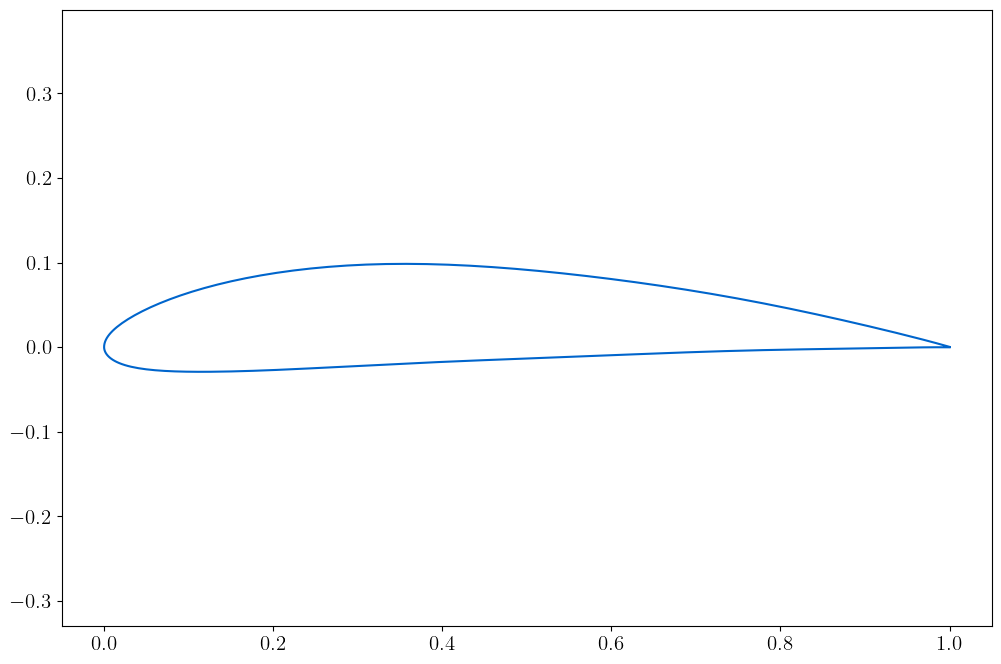

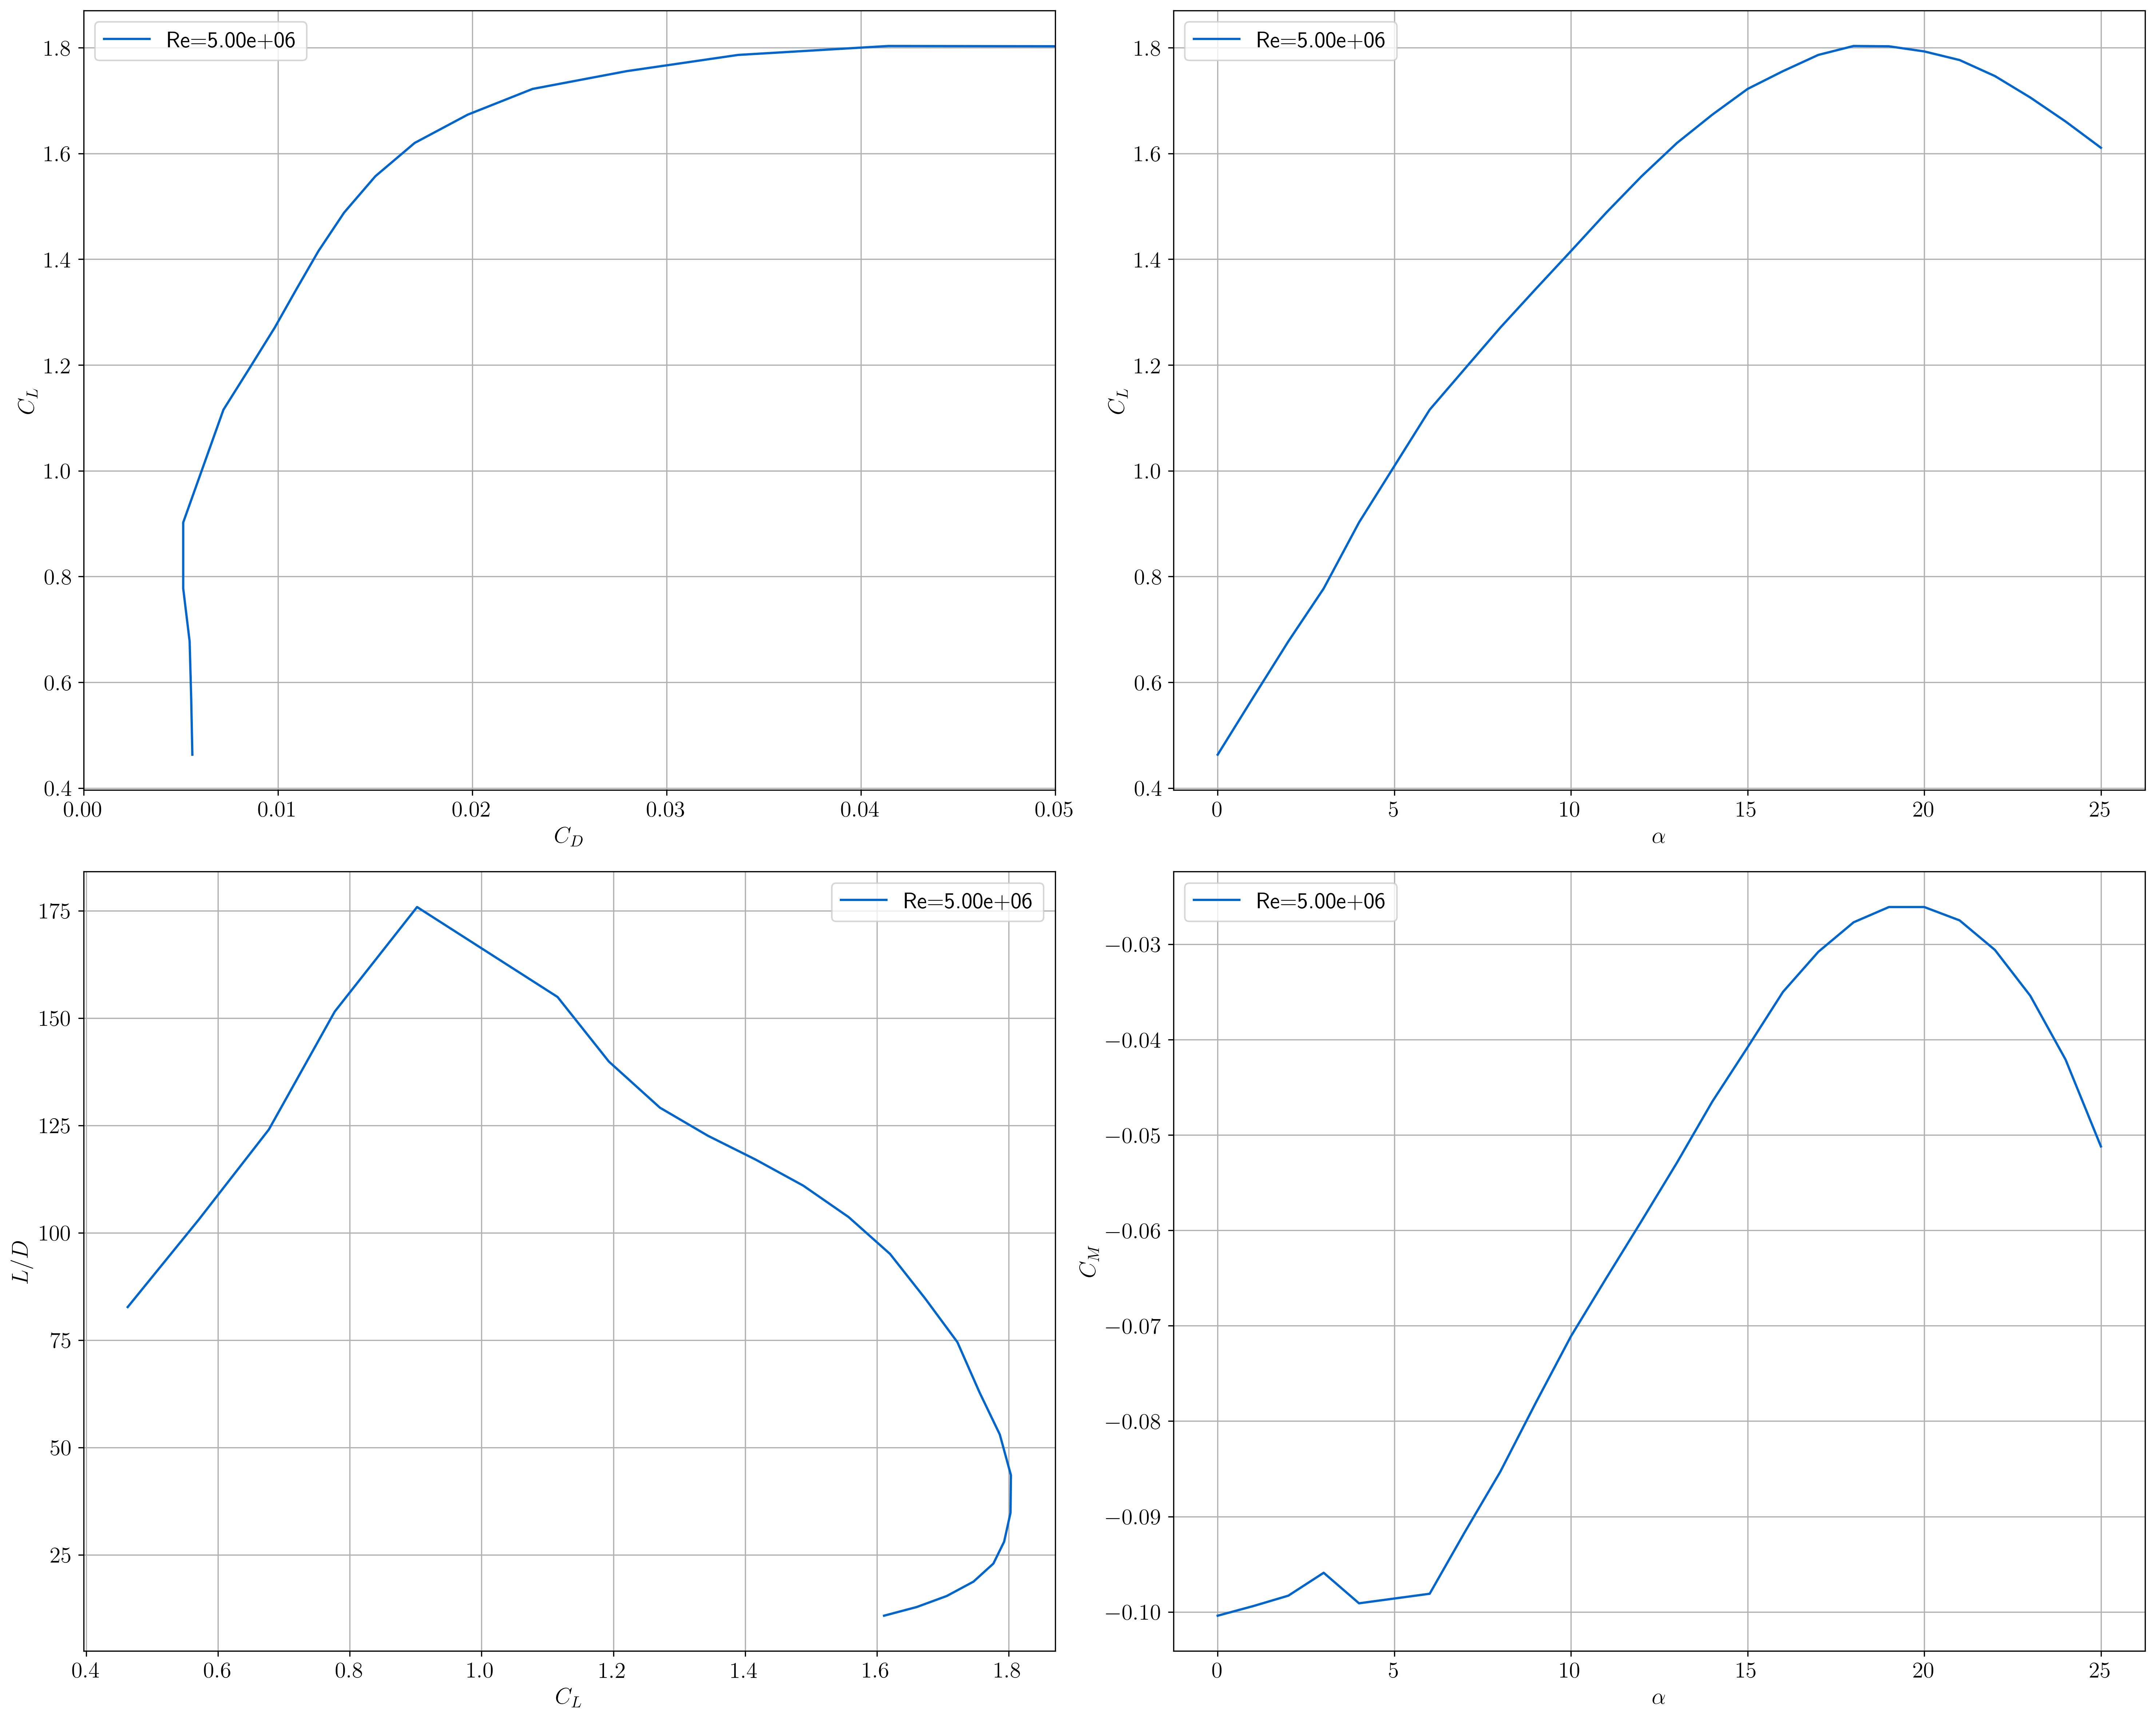

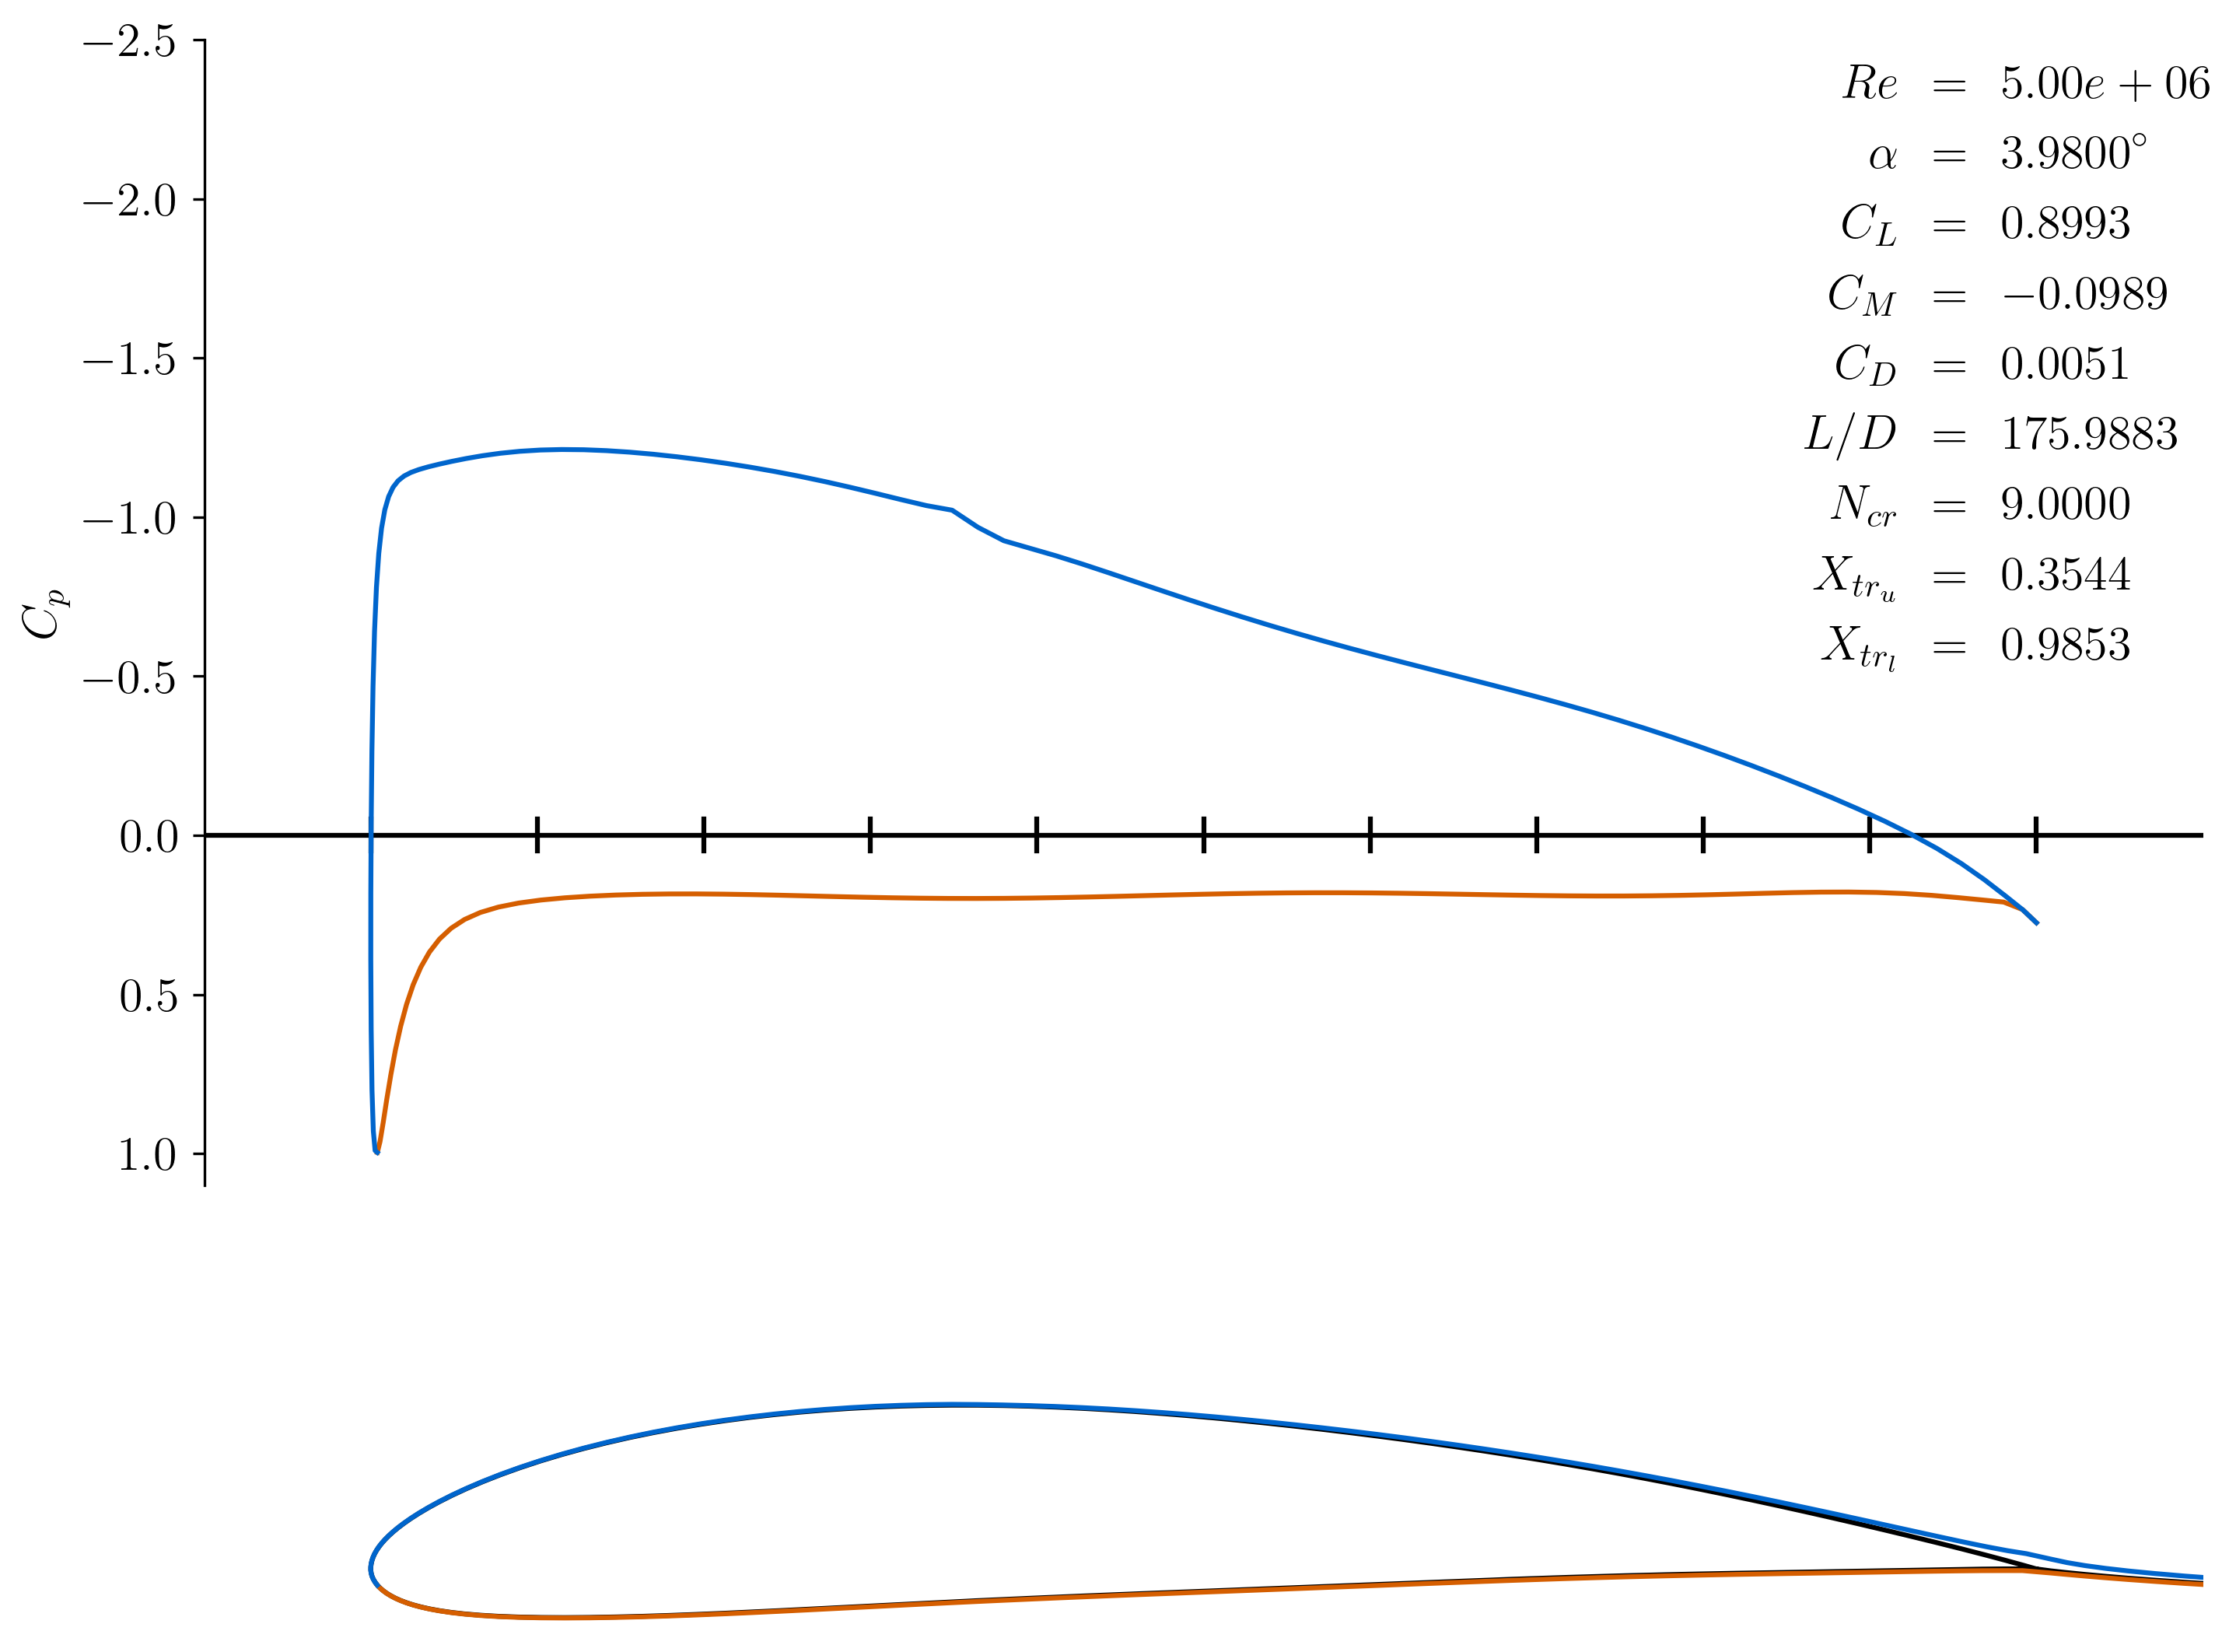

In [10]:
afl1 = Kulfan()
afl1.naca4('4412')
afl1.changeOrder(8)

CL = 0.9
Re = 5e6

plt.figure(figsize=(12,8))
plt.plot(afl1.xcoordinates, afl1.ycoordinates)
plt.axis('equal');

an = 0
ax = 25
ab = 26

data_all = []
dta_runs = []
for alpha in np.linspace(an,ax,ab):
    dta = run_xfoil('alpha',afl1.upperCoefficients, afl1.lowerCoefficients, alpha, Re, 0, 1, 1, 9)
    if dta is not None:
        dta_runs.append(dta)
data_all.append(dta_runs)

fg1 = polarPlot(data_all,[colors[0]],['-'])

a_arr = []
for alcs in range(0,len(data_all)):
    alph = [d['alpha'] for d in data_all[alcs] ]
    ix = 0
    for i, aa in enumerate(alph):
        if i != 0:
            if alph[i-1]<= alph[i]:
                ix = i
    cll  = [d['cl'] for d in data_all[alcs] ]
    a_arr.append(np.interp(CL, cll[0:ix], alph[0:ix]))

data_all = []
dta = run_xfoil('alpha',afl1.upperCoefficients, afl1.lowerCoefficients, a_arr[0], Re, 0, 1, 1, 9)
data_all.append(dta)
fg1 = standardPlot(data_all)
plt.show()
